In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from vine_copulas import PartnerSelector

# Partner Selection for Statistical Arbitrage with Vine Copulas.

## Abstract

In this [paper](https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf), Stubinger, J., Mangold, B., and Krauss, C. takes inspiration from two-dimensional pairs trading frameworks and constructs a multivariate statistical arbitrage strategy based on vine copulas.

## Introduction

The methodology described in the paper consists of an initialization period that is broken up into the following 2 stages:

- Partner Selection
- Model Fit

This notebook focuses on the Partner Selection procedures. More specifically, we will be applying the framework to stocks in the S&P500 and identify 4 stock combinations for the strategy. Each combination will consist of the target stock and 3 partner stocks.

## Methodology

The paper outlines the following methods for measuring associations between potential combinations of stocks.
- Traditional
- Extended
- Geometric
- Extremal*

Examples of retrieving partner combinations for supported methods are shown below.

** Not currently supported*

### Data
First we load 12 months of daily closing prices for stocks in the S&P500.

In [2]:
data_close = pd.read_csv('data/sp500_2015.csv')
data_close = data_close.set_index('Date').dropna(axis=1)
data_close.index = pd.to_datetime(data_close.index)
data_close.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,40.560001,53.910000,158.559998,27.332500,65.889999,90.459999,37.310001,44.900002,88.839996,72.339996,...,43.599998,92.830002,51.930000,36.231884,38.080002,52.012939,112.589996,77.430000,28.290001,43.310001
2015-01-05,39.799999,53.880001,156.470001,26.562500,64.650002,89.690002,37.070000,44.910000,87.339996,71.980003,...,42.799999,90.290001,51.570000,35.441368,35.709999,50.956146,116.790001,76.339996,27.230000,43.049999
2015-01-06,39.180000,53.040001,156.360001,26.565001,64.330002,90.180000,36.130001,44.400002,86.709999,70.529999,...,42.180000,89.809998,50.930000,34.967064,35.500000,50.330696,115.800003,75.790001,26.190001,42.630001
2015-01-07,39.700001,53.009998,159.720001,26.937500,66.930000,91.980003,37.279999,44.759998,88.529999,71.110001,...,42.200001,90.720001,52.250000,35.415020,35.779999,51.998562,118.680000,77.720001,26.440001,43.509998
2015-01-08,40.889999,53.660000,161.119995,27.972500,67.629997,92.190002,38.959999,45.680000,89.879997,72.919998,...,43.139999,92.230003,53.540001,36.389988,36.049999,52.904385,119.940002,79.379997,26.809999,44.180000


### Pre-selection

All measures of association in the methods below are based on the ordinal ranks of the discrete returns of our sample data. This is done to reduce the impact of outlier data.

Additionally, the number of potential partner combinations scales exponentially with the number of dimensions in our model. To reduce computational complexity, we specify a threshold *m* where only the top *m* most correlated stocks are considered for partner selection. 

In [3]:
dimensions = 4
threshold = 50
selector = PartnerSelector(data_close, dimensions=dimensions, threshold=threshold)

Calculating preselections: 100%|██████████| 486/486 [01:03<00:00,  7.71it/s]


In [4]:
# List of potential partner combinations
selector.get_partner_data('AAPL')['tickers']

0        [AAPL, ITW, HON, AVGO]
1         [AAPL, ITW, HON, CMI]
2         [AAPL, ITW, HON, NOC]
3         [AAPL, ITW, HON, IBM]
4          [AAPL, ITW, HON, TT]
                  ...          
19595      [AAPL, HPQ, FB, IVZ]
19596       [AAPL, NLSN, C, FB]
19597      [AAPL, NLSN, C, IVZ]
19598     [AAPL, NLSN, FB, IVZ]
19599        [AAPL, C, FB, IVZ]
Name: tickers, Length: 19600, dtype: object

In [5]:
def plot_prices_norm(df, title):
    """Plot normalized price data"""
    norm_df = df/df.iloc[0,:]
    months = mdates.MonthLocator()
    date_fmt = mdates.ConciseDateFormatter(months)
    datemin = norm_df.index[0]
    datemax = norm_df.index[-1]
    
    plt.figure(figsize=(8,3.5))
    plt.title(title)
    ax = sns.lineplot(data=norm_df)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.set_xlim(datemin, datemax)
    plt.show()

### Method 1: Traditional

This method computes the sum of the pairwise Spearman's correlation for each combination. The combination with the highest value is used for the result output.

An optional list can be provided to only compute the partners for a subset of target stocks.

In [6]:
target_tickers = None
# Comment line below to compute partners for all tickers in data set
target_tickers = ['A', 'AAL', 'AAPL', 'IBM', 'SWKS', 'WFC'] 

In [7]:
partners_traditional = selector.get_partners(method=PartnerSelector.Method.TRADITIONAL, targets=target_tickers)
partners_traditional[0:5]

Calculating traditional Spearman associations: 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


[['A', 'CB', 'CINF', 'TRV'],
 ['AAL', 'DAL', 'UAL', 'LUV'],
 ['AAPL', 'WFC', 'USB', 'C'],
 ['IBM', 'CB', 'CINF', 'TRV'],
 ['SWKS', 'ADI', 'TXN', 'MCHP']]

### Method 2: Extended Spearman

This method uses the generalized Spearman's rho described by Schmid, F., Schmidt, R., (2007) Multivariate extensions of Spearman’s rho and related statistics. The technique computes the rank based correlation coefficient for multivariate samples. 

In [8]:
partners_extended = selector.get_partners(method=PartnerSelector.Method.EXTENDED, targets=target_tickers)
partners_extended[0:5]

Calculating extended Spearman associations: 100%|██████████| 6/6 [00:20<00:00,  3.47s/it]


[['A', 'CB', 'CINF', 'TRV'],
 ['AAL', 'DAL', 'UAL', 'LUV'],
 ['AAPL', 'WFC', 'USB', 'C'],
 ['IBM', 'CB', 'CINF', 'TRV'],
 ['SWKS', 'ADI', 'TXN', 'MCHP']]

### Method 3: Geometric

Given a Q-Q plot in 4-dimensions, the diagonal along this space represents a perfect correlation. In this method, we compute the distance to the diagonal from each sample and take the sum. The combination with the minimum aggregrate distance is taken as the output partner combination.

In [9]:
partners_geometric = selector.get_partners(method=PartnerSelector.Method.GEOMETRIC, targets=target_tickers)
partners_geometric[0:5]

Calculating geometric associations: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


[['A', 'CB', 'CINF', 'TRV'],
 ['AAL', 'DAL', 'UAL', 'LUV'],
 ['AAPL', 'WFC', 'USB', 'C'],
 ['IBM', 'CB', 'CINF', 'TRV'],
 ['SWKS', 'ADI', 'TXN', 'MCHP']]

Naturally, the ideal partners with this method show that the distribution of distances is skewed towards 0.

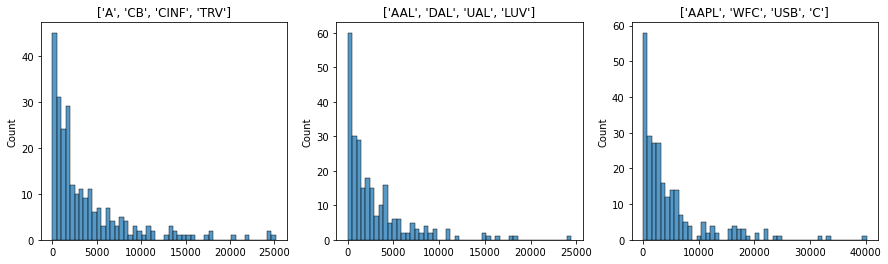

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i in range(0,3):
    p = partners_geometric[i]
    axes[i].set_title(p)
    geo_dist = selector.get_geometric_distance(p)
    sns.histplot(ax=axes[i], data=geo_dist, bins=50)

### Review
Here we can see the normalized prices for some of the partner results.

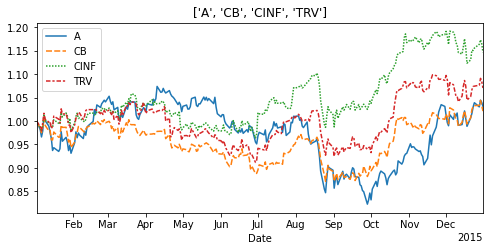

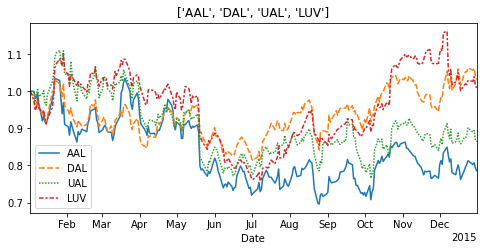

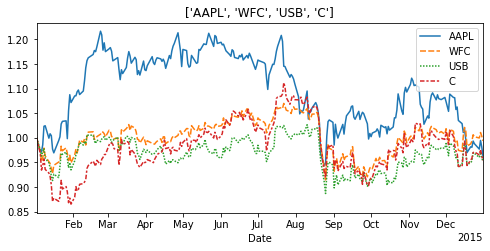

In [15]:
for i in range(0,3):
    p = partners_extended[i]
    plot_prices_norm(data_close[p], p)

## Conclusion

In this notebook, we've demonstrated usage of the `PartnerSelector` class to determine ideal partner combinations of arbitrary dimensions. These partner outputs can then be used in the multivariate statistical arbitrage framework described by Stubinger, J., Mangold, B., Krauss, C. (2016).

Next steps include:
- Implement *Extremal* selection method
- Optimizations: There are likely additional micro-optimizations around to improve processing time. The algorithms are also easily parallelizable and can be modified to support multi-threading or distributed computing.